# Single-cell RNA sequencing of human iPSC-derived cells
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE130731

Cardiomyocyte Differentiation (GSE130731)

Source: Two pooled hiPSC lines
Timepoints Used: Days 0, 2, 4, 10
Preprocessing: Used precomputed matrices and metadata from authors
Application: Examined if CNAs distinguish cell lines during cardiomyocyte fate commitment


#**Loading packages and preprocessing**


In [ ]:
# Install packages
!pip install scanpy scipy umap-learn leidenalg scFates
!pip install hmmlearn


In [ ]:
import os, sys
os.environ['R_HOME'] = sys.exec_prefix+"/lib/R/"
import scanpy as sc
import scFates as scf
import numpy as np
import pandas as pd
from anndata import AnnData
from typing import Dict, Tuple
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from scipy.sparse import issparse


In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Define base path
drive_base = "/content/drive/MyDrive/compscfiles/task3finalproject"
raw_dir = os.path.join(drive_base, "raw", "GSE130731")
os.makedirs(raw_dir, exist_ok=True)

# Download the TAR file
!wget -O {raw_dir}/GSE130731_RAW.tar "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE130nnn/GSE130731/suppl/GSE130731_RAW.tar"


--2025-05-06 22:40:26--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE130nnn/GSE130731/suppl/GSE130731_RAW.tar
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.13, 130.14.250.31, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 586997760 (560M) [application/x-tar]
Saving to: ‘/content/drive/MyDrive/compscfiles/task3finalproject/raw/GSE130731/GSE130731_RAW.tar’

/content/drive/MyDr 100%[===================>] 559.80M  21.9MB/s    in 29s     

2025-05-06 22:40:57 (19.2 MB/s) - ‘/content/drive/MyDrive/compscfiles/task3finalproject/raw/GSE130731/GSE130731_RAW.tar’ saved [586997760/586997760]



In [ ]:
# First extract outer TAR
!tar -xvf {raw_dir}/GSE130731_RAW.tar -C {raw_dir}

# Optional: Extract each inner .tar.gz if needed
import glob
inner_tars = glob.glob(f"{raw_dir}/*.tar.gz")
for f in inner_tars:
    !tar -xvzf "{f}" -C "{raw_dir}"


GSM3752596_iPS_0.barcodes.genes.matrix.tar.gz
GSM3752598_iPS_1.barcodes.genes.matrix.tar.gz
GSM3752600_iPS_2.barcodes.genes.matrix.tar.gz
GSM3752602_iPS_3.barcodes.genes.matrix.tar.gz
iPS_0.barcodes.genes.matrix/
iPS_0.barcodes.genes.matrix/barcodes.tsv
iPS_0.barcodes.genes.matrix/genes.tsv
iPS_0.barcodes.genes.matrix/matrix.mtx
iPS_1.barcodes.genes.matrix/
iPS_1.barcodes.genes.matrix/barcodes.tsv
iPS_1.barcodes.genes.matrix/genes.tsv
iPS_1.barcodes.genes.matrix/matrix.mtx
iPS_2.barcodes.genes.matrix/
iPS_2.barcodes.genes.matrix/barcodes.tsv
iPS_2.barcodes.genes.matrix/genes.tsv
iPS_2.barcodes.genes.matrix/matrix.mtx
iPS_3.barcodes.genes.matrix/
iPS_3.barcodes.genes.matrix/barcodes.tsv
iPS_3.barcodes.genes.matrix/genes.tsv
iPS_3.barcodes.genes.matrix/matrix.mtx


In [ ]:
import scanpy as sc
import os

# Define paths to each sample
base_path = "/content/drive/MyDrive/compscfiles/task3finalproject/raw/GSE130731"
sample_folders = [
    "iPS_0.barcodes.genes.matrix",
    "iPS_1.barcodes.genes.matrix",
    "iPS_2.barcodes.genes.matrix",
    "iPS_3.barcodes.genes.matrix"
]
sample_paths = [os.path.join(base_path, f) for f in sample_folders]

# Load and tag
adatas = []
for i, path in enumerate(sample_paths):
    ad = sc.read_10x_mtx(path, var_names="gene_symbols", cache=True)
    ad.obs["sample"] = f"iPS_{i}"
    ad.obs_names = [f"iPS_{i}_{x}" for x in ad.obs_names]
    adatas.append(ad)

# Concatenate all samples
adata = adatas[0].concatenate(adatas[1:], batch_key="sample_id", batch_categories=[f"iPS_{i}" for i in range(4)])

# Save combined object
adata.write("/content/drive/MyDrive/compscfiles/task3finalproject/GSE130731_combined.h5ad")
print(f"Saved combined AnnData with shape {adata.shape}")



<ipython-input-6-34a3d99e6cac>:23: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adatas[0].concatenate(adatas[1:], batch_key="sample_id", batch_categories=[f"iPS_{i}" for i in range(4)])


Saved combined AnnData with shape (2949120, 33694)


In [ ]:
import numpy as np

# Load full dataset
adata = sc.read_h5ad("/content/drive/MyDrive/compscfiles/task3finalproject/GSE130731_combined.h5ad")

# Randomly sample 50,000 cells
np.random.seed(42)
subset = np.random.choice(adata.n_obs, size=50000, replace=False)
adata_sub = adata[subset].copy()

# Save smaller version
adata_sub.write("/content/drive/MyDrive/compscfiles/task3finalproject/GSE130731_subsampled_50k.h5ad")
print(" Subsampled AnnData saved.")


 Subsampled AnnData saved.


In [ ]:
adata_sub

AnnData object with n_obs × n_vars = 50000 × 33694
    obs: 'sample', 'sample_id'
    var: 'gene_ids'

In [ ]:
!wget https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.annotation.gtf.gz -O gencode.v43.gtf.gz


--2025-05-06 22:44:27--  https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_43/gencode.v43.annotation.gtf.gz
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49661267 (47M) [application/x-gzip]
Saving to: ‘gencode.v43.gtf.gz’

gencode.v43.gtf.gz  100%[===================>]  47.36M  10.9MB/s    in 4.5s    

2025-05-06 22:44:33 (10.4 MB/s) - ‘gencode.v43.gtf.gz’ saved [49661267/49661267]



In [ ]:
import pandas as pd
import scanpy as sc

# Load gene coordinates
def load_gene_coords(gtf_file):
    df = pd.read_csv(
        gtf_file,
        sep='\t',
        comment='#',
        header=None,
        names=["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]
    )
    df = df[df["feature"] == "gene"]
    df["gene_name"] = df["attribute"].str.extract('gene_name "([^"]+)"')
    df["gene_id"] = df["attribute"].str.extract('gene_id "([^"]+)"')
    return df[["gene_id", "gene_name", "seqname", "start", "end"]].rename(
        columns={"seqname": "chromosome"}
    )

# Load GTF annotations
gene_df = load_gene_coords("gencode.v43.gtf.gz")

# Load your AnnData
adata = sc.read_h5ad("/content/drive/MyDrive/compscfiles/task3finalproject/GSE130731_subsampled_50k.h5ad")

# Match gene_id in var
adata.var.index.name = "gene_id"
matched = gene_df.set_index("gene_id").reindex(adata.var.index)

# Add annotations
adata.var["gene_name"] = matched["gene_name"].values
adata.var["chromosome"] = matched["chromosome"].values
adata.var["start"] = matched["start"].values
adata.var["end"] = matched["end"].values



In [ ]:
# Convert all adata.var columns to string to prevent HDF5 errors
for col in ["gene_name", "chromosome", "start", "end"]:
    adata.var[col] = adata.var[col].astype(str)


adata.write("/content/drive/MyDrive/compscfiles/task3finalproject/GSE130731_subsampled_50k_annotated.h5ad")
print(" Finished: added gene_name, chromosome, start, end.")


 Finished: added gene_name, chromosome, start, end.


In [ ]:
adata

AnnData object with n_obs × n_vars = 50000 × 33694
    obs: 'sample', 'sample_id'
    var: 'gene_ids', 'gene_name', 'chromosome', 'start', 'end'

In [ ]:
adata.var

,gene_ids,gene_name,chromosome,start,end
gene_id,,,,,
RP11-34P13.3,ENSG00000243485,nan,nan,nan,nan
FAM138A,ENSG00000237613,nan,nan,nan,nan
OR4F5,ENSG00000186092,nan,nan,nan,nan
RP11-34P13.7,ENSG00000238009,nan,nan,nan,nan
RP11-34P13.8,ENSG00000239945,nan,nan,nan,nan
...,...,...,...,...,...
AC233755.2,ENSG00000277856,nan,nan,nan,nan
AC233755.1,ENSG00000275063,nan,nan,nan,nan
AC240274.1,ENSG00000271254,nan,nan,nan,nan


In [ ]:
def load_gene_coords(gtf_file):
    df = pd.read_csv(
        gtf_file,
        sep='\t',
        comment='#',
        header=None,
        names=["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]
    )
    df = df[df["feature"] == "gene"]
    df["gene_name"] = df["attribute"].str.extract('gene_name "([^"]+)"')
    df["gene_id"] = df["attribute"].str.extract('gene_id "([^"]+)"')

    # Strip version suffix from gene_id (e.g., ENSG00000123456.3 → ENSG00000123456)
    df["gene_id"] = df["gene_id"].str.replace(r"\.\d+$", "", regex=True)

    return df[["gene_id", "gene_name", "seqname", "start", "end"]].rename(
        columns={"seqname": "chromosome"}
    )



In [ ]:
gene_df = load_gene_coords("gencode.v43.gtf.gz")
gene_df.set_index("gene_id", inplace=True)
matched = gene_df.reindex(adata.var["gene_ids"])

adata.var["gene_name"] = matched["gene_name"].values
adata.var["chromosome"] = matched["chromosome"].values
adata.var["start"] = matched["start"].values
adata.var["end"] = matched["end"].values


In [ ]:
adata

AnnData object with n_obs × n_vars = 50000 × 33694
    obs: 'sample', 'sample_id'
    var: 'gene_ids', 'gene_name', 'chromosome', 'start', 'end'

In [ ]:
adata.var

,gene_ids,gene_name,chromosome,start,end
gene_id,,,,,
RP11-34P13.3,ENSG00000243485,MIR1302-2HG,chr1,29554.0,31109.0
FAM138A,ENSG00000237613,FAM138A,chr1,34554.0,36081.0
OR4F5,ENSG00000186092,OR4F5,chr1,65419.0,71585.0
RP11-34P13.7,ENSG00000238009,ENSG00000238009,chr1,89295.0,133723.0
RP11-34P13.8,ENSG00000239945,ENSG00000239945,chr1,89551.0,91105.0
...,...,...,...,...,...
AC233755.2,ENSG00000277856,NaN,NaN,NaN,NaN
AC233755.1,ENSG00000275063,NaN,NaN,NaN,NaN
AC240274.1,ENSG00000271254,NaN,NaN,NaN,NaN


In [ ]:
# Step 1: Remove genes with missing or malformed gene_id or gene_name
# (e.g., no ENSG ID or gene name is NaN or same as ID)
valid_ids = adata.var["gene_ids"].str.startswith("ENSG")
valid_names = adata.var["gene_name"].notnull() & (adata.var["gene_name"] != adata.var["gene_ids"])
valid_locs = adata.var[["chromosome", "start", "end"]].notnull().all(axis=1)

# Combine all filters
valid_genes = valid_ids & valid_names & valid_locs

# Apply filter
adata = adata[:, valid_genes]
print(f" After removing low-quality genes: {adata.shape}")


 After removing low-quality genes: (50000, 24745)


In [ ]:
adata.var_names = adata.var["gene_name"]
adata.var_names_make_unique()

# Optionally drop old redundant index
adata.var.reset_index(drop=True, inplace=True)

# Preview final var
adata


AnnData object with n_obs × n_vars = 50000 × 24745
    obs: 'sample', 'sample_id'
    var: 'gene_ids', 'gene_name', 'chromosome', 'start', 'end'

In [ ]:
adata

AnnData object with n_obs × n_vars = 50000 × 24745
    obs: 'sample', 'sample_id'
    var: 'gene_ids', 'gene_name', 'chromosome', 'start', 'end'

In [ ]:
adata.var

,gene_ids,gene_name,chromosome,start,end
0,ENSG00000243485,MIR1302-2HG,chr1,29554.0,31109.0
1,ENSG00000237613,FAM138A,chr1,34554.0,36081.0
2,ENSG00000186092,OR4F5,chr1,65419.0,71585.0
3,ENSG00000279928,DDX11L17,chr1,182696.0,184174.0
4,ENSG00000279457,WASH9P,chr1,185217.0,195411.0
...,...,...,...,...,...
24740,ENSG00000212907,MT-ND4L,chrM,10470.0,10766.0
24741,ENSG00000198886,MT-ND4,chrM,10760.0,12137.0
24742,ENSG00000198786,MT-ND5,chrM,12337.0,14148.0
24743,ENSG00000198695,MT-ND6,chrM,14149.0,14673.0


In [ ]:
# Correct day assignments from GEO metadata
day_map = {
    "iPS_0": 0,
    "iPS_1": 1,
    "iPS_2": 2,
    "iPS_3": 3
}

# Apply the corrected mapping
adata.obs["day"] = adata.obs["sample_id"].map(day_map)

# Verify
adata.obs[["sample_id", "day"]].head()




,sample_id,day
iPS_0_TGACTAGCATGCTGGC-1-iPS_0,iPS_0,0
iPS_0_CACAAACGTTCCGGCA-1-iPS_0,iPS_0,0
iPS_2_CCGGTAGGTTCGCGAC-1-iPS_2,iPS_2,2
iPS_2_ACTGAACGTTTCCACC-1-iPS_2,iPS_2,2
iPS_2_CTACACCGTATAGTAG-1-iPS_2,iPS_2,2


In [ ]:
adata

AnnData object with n_obs × n_vars = 50000 × 24745
    obs: 'sample', 'sample_id', 'day'
    var: 'gene_ids', 'gene_name', 'chromosome', 'start', 'end'

#**Finding Reference Cluster**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import issparse

def plot_group_means_by_genomic_position(adata, layer="counts", group_by="day", downsample=100):
    """
    Plot mean expression across genomic positions for each group in `adata.obs[group_by]`.

    Parameters:
    - adata: AnnData object with `.layers[layer]` and `.obs[group_by]`
    - layer: Name of the layer with expression data (e.g., 'counts')
    - group_by: Column in `adata.obs` to group cells by (e.g., 'day')
    - downsample: Downsample genes by selecting every nth gene
    """
    # Indexes of genes to downsample
    gene_indices = np.arange(0, adata.n_vars, downsample)

    # Extract gene-level metadata
    var = adata.var.iloc[gene_indices]
    chromosomes = var["chromosome"].astype(str).values

    # Identify valid chromosomes and chromosome transitions
    valid_chroms = [str(i) for i in range(1, 23)] + ['X', 'chrX']
    chrom_mask = np.isin(chromosomes, valid_chroms)
    chrom_changes = np.where((chromosomes[:-1] != chromosomes[1:]) &
                             (chrom_mask[:-1] | chrom_mask[1:]))[0] + 1
    chrom_boundaries = [0] + chrom_changes.tolist() + [len(chromosomes)]
    chrom_midpoints = [(chrom_boundaries[i] + chrom_boundaries[i+1]) // 2
                       for i in range(len(chrom_boundaries)-1)]
    chrom_labels = [chromosomes[i] for i in chrom_boundaries[:-1]]

    # Compute mean expression per group
    all_means = []
    groups = adata.obs[group_by].dropna().unique()
    for group in sorted(groups):
        mask = adata.obs[group_by] == group
        X = adata[mask].layers[layer][:, gene_indices]
        if issparse(X):
            X = X.toarray()
        all_means.append(np.mean(X, axis=0))

    # Global y-axis limits
    global_ymin = min(np.min(m) for m in all_means)
    global_ymax = max(np.max(m) for m in all_means)
    ypad = (global_ymax - global_ymin) * 0.1

    # --- Combined Plot ---
    plt.figure(figsize=(14, 6))
    for group, mean in zip(sorted(groups), all_means):
        plt.plot(mean, label=f"Day {group}", linewidth=1)

    for x in chrom_boundaries[1:-1]:
        if chrom_mask[x]:
            plt.axvline(x, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
    plt.xticks(
        [mp for mp, lbl in zip(chrom_midpoints, chrom_labels) if lbl in valid_chroms],
        [lbl for lbl in chrom_labels if lbl in valid_chroms],
        rotation=90
    )
    plt.ylim(global_ymin - ypad, global_ymax + ypad)
    plt.title(f"Mean Expression Across Genomic Position (Grouped by {group_by})")
    plt.xlabel("Genomic Position")
    plt.ylabel("Mean Counts")
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()

    # --- Per-group plots ---
    for group, mean in zip(sorted(groups), all_means):
        plt.figure(figsize=(14, 4))
        plt.plot(mean, color='steelblue', linewidth=1)
        for x in chrom_boundaries[1:-1]:
            if chrom_mask[x]:
                plt.axvline(x, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)
        plt.xticks(
            [mp for mp, lbl in zip(chrom_midpoints, chrom_labels) if lbl in valid_chroms],
            [lbl for lbl in chrom_labels if lbl in valid_chroms],
            rotation=90
        )
        plt.ylim(global_ymin - ypad, global_ymax + ypad)
        plt.title(f"Day {group} — Mean Expression (Downsampled every {downsample} genes)")
        plt.xlabel("Genomic Position")
        plt.ylabel("Mean Counts")
        plt.tight_layout()
        plt.show()


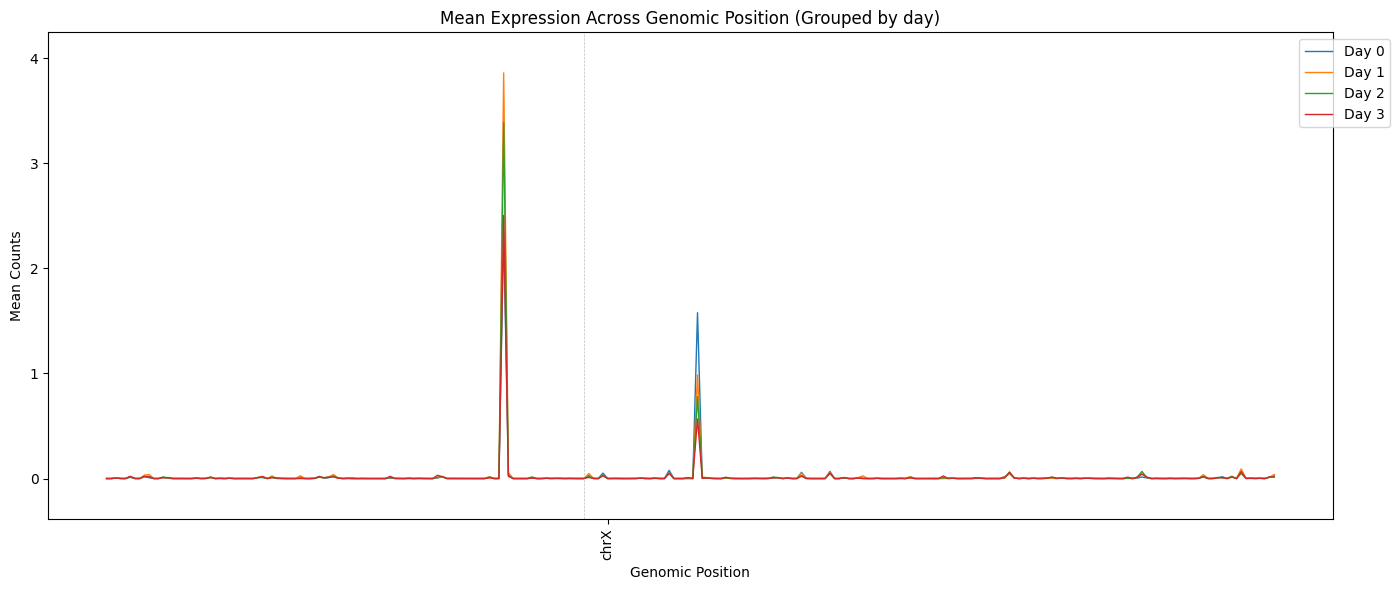

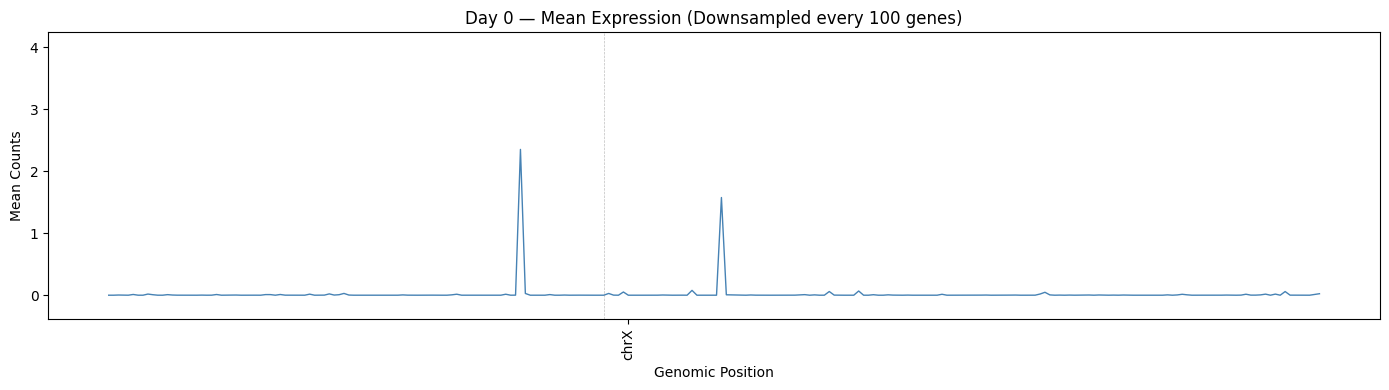

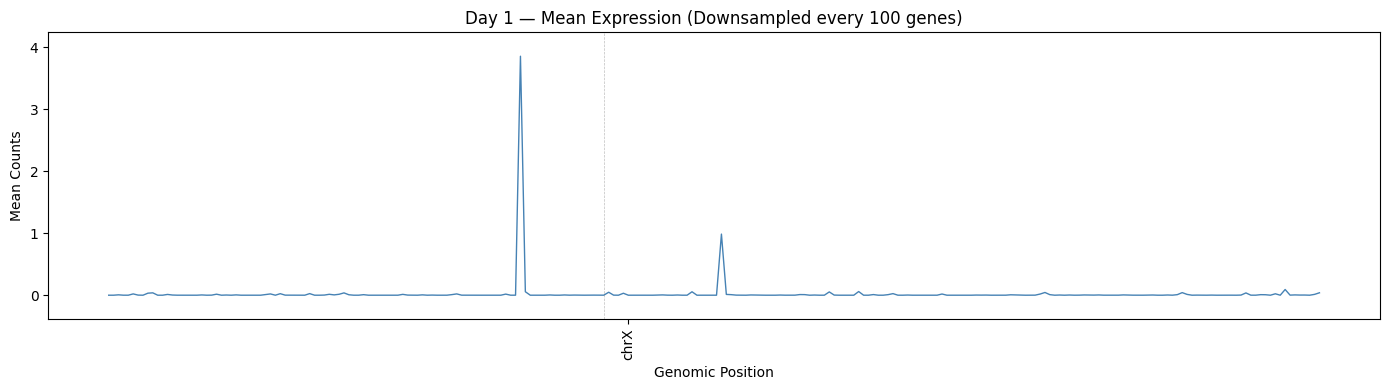

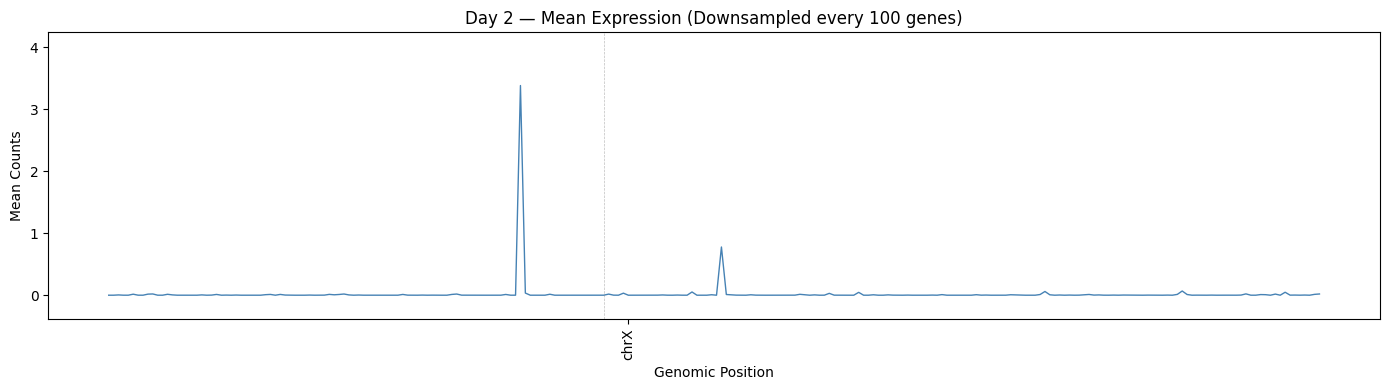

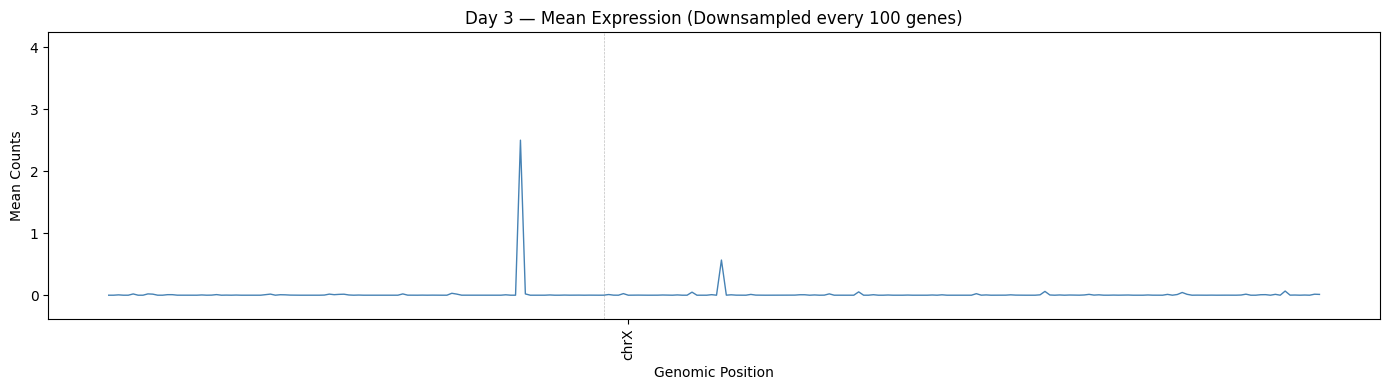

In [ ]:
adata.layers["counts"] = adata.X.copy()

plot_group_means_by_genomic_position(adata, layer="counts", group_by="day", downsample=100)



In [ ]:
# day 0 cell seems to have lowest baseline expression

#**Smoothing (2)**

In [ ]:
from typing import Tuple, Dict
import pandas as pd
from anndata import AnnData

def order_genes_by_position(adata: AnnData) -> AnnData:
    """
    Orders genes in the AnnData object by chromosome and start position.
    """
    gene_order = (
        adata.var
        .sort_values(['chromosome', 'start'])
        .index
    )
    return adata[:, gene_order]


def smooth_expression_matrix(matrix: pd.DataFrame, window_size: int = 25) -> pd.DataFrame:
    """
    Applies a sliding window average across genes.
    """
    smoothed = []
    gene_names = matrix.columns.to_list()

    for i in range(len(gene_names) - window_size + 1):
        window = gene_names[i:i + window_size]
        avg_expr = matrix[window].mean(axis=1)
        smoothed.append(avg_expr.rename(f"{window[0]}_to_{window[-1]}"))

    return pd.concat(smoothed, axis=1)


def compute_smoothed_profiles_from_adata(
    adata: AnnData,
    use_layer: str = None,
    group_by: str = 'day',
    window_size: int = 25,
    ref: int = 0  # Use day 0 as reference by default
) -> Tuple[pd.DataFrame, Dict[int, pd.Series], pd.Series, pd.Series]:
    """
    Computes smoothed expression profiles grouped by `day` (or any `obs` field).

    Returns:
    - Per-cell smoothed expression DataFrame
    - Dictionary of per-day smoothed average Series
    - Global average Series
    - Reference group average Series
    """
    # Step 1: Order genes by genome coordinates
    adata_ordered = order_genes_by_position(adata)

    # Step 2: Extract expression matrix
    if use_layer:
        expr = pd.DataFrame(
            adata_ordered.layers[use_layer].toarray(),
            index=adata_ordered.obs_names,
            columns=adata_ordered.var_names
        )
    else:
        expr = pd.DataFrame(
            adata_ordered.X.toarray() if hasattr(adata_ordered.X, "toarray") else adata_ordered.X,
            index=adata_ordered.obs_names,
            columns=adata_ordered.var_names
        )

    # Step 3: Smooth once for all cells
    smoothed_expr = smooth_expression_matrix(expr, window_size)

    # Step 4: Global average
    global_avg = smoothed_expr.mean(axis=0)

    # Step 5: Per-day averages (vectorized)
    group_vals = adata_ordered.obs[group_by]
    group_profiles = {
        val: smoothed_expr.loc[group_vals == val].mean(axis=0)
        for val in sorted(group_vals.unique())
    }

    # Step 6: Reference group average
    if ref in group_profiles:
        ref_avg = group_profiles[ref]
    else:
        raise ValueError(f"Reference group '{ref}' not found in adata.obs['{group_by}'].")

    return smoothed_expr, group_profiles, global_avg, ref_avg


In [ ]:
# Limit to 1000 cells per day to reduce memory usage
subset_indices = (
    adata.obs.groupby("day")
    .sample(n=1000, random_state=42)
    .index
)

adata_subset = adata[subset_indices].copy()

smoothed, day_avg, global_avg, ref_day_avg = compute_smoothed_profiles_from_adata(
    adata_subset,
    use_layer="counts",
    group_by="day",
    window_size=25,
    ref=0
)


<ipython-input-28-8eb8ab53f0b2>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby("day")
/usr/local/lib/python3.11/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
def compute_all_cell_zscores_to_adata_optimized(smoothed: pd.DataFrame,
                                                group_avg: dict,
                                                global_avg: pd.Series,
                                                ref_avg: pd.Series,
                                                adata: AnnData,
                                                group_by: str = 'day') -> AnnData:
    """
    Computes per-cell z-scores of smoothed expression deltas relative to:
    - global average
    - group (day) average
    - reference day (e.g., day 0) average

    Stores results in adata.obsm.
    """
    import numpy as np

    cells = smoothed.index
    genes = smoothed.columns
    n_cells, n_genes = smoothed.shape

    smoothed_np = smoothed.values
    global_avg_np = global_avg.loc[genes].values
    ref_avg_np = ref_avg.loc[genes].values

    # Get per-group (day) average for each cell
    groups = adata.obs.loc[cells, group_by].values
    group_avg_np = np.stack([group_avg[g].loc[genes].values for g in groups])

    # Helper: row-wise z-score
    def zscore_rowwise(matrix):
        mean = matrix.mean(axis=1, keepdims=True)
        std = matrix.std(axis=1, keepdims=True)
        std[std == 0] = 1
        return (matrix - mean) / std

    # Compute deltas
    delta_global = smoothed_np - global_avg_np
    delta_group  = smoothed_np - group_avg_np
    delta_ref    = smoothed_np - ref_avg_np

    # Z-score normalize per cell
    delta_global_z = zscore_rowwise(delta_global)
    delta_group_z  = zscore_rowwise(delta_group)
    delta_ref_z    = zscore_rowwise(delta_ref)

    # Store in adata.obsm
    adata.obsm['delta_global_z']  = delta_global_z
    adata.obsm['delta_group_z']   = delta_group_z
    adata.obsm['delta_ref_z']     = delta_ref_z
    adata.uns['delta_zscore_genes'] = list(genes)

    return adata


In [ ]:
adata = compute_all_cell_zscores_to_adata_optimized(
    smoothed,
    group_avg=day_avg,       # previously: celltype_avg
    global_avg=global_avg,
    ref_avg=ref_day_avg,     # day 0 average
    adata=adata_subset,      # use subset for performance
    group_by="day"
)


In [ ]:
def filter_and_count_zscores(
    zscore_array,
    upper_thresh: float = 1.0,
    lower_thresh: float = -1.0,
    min_cells: int = 600,
    adata: AnnData = None,
    obsm_key: str = None
) -> Tuple[pd.DataFrame, pd.Series, pd.Series]:
    """
    Robust z-score filtering with proper AnnData alignment

    Parameters:
        zscore_array: Input array (cells × genes)
        upper_thresh/lower_thresh: Significance thresholds
        min_cells: Minimum cells with significant changes
        adata: AnnData object (must match zscore_array rows)
        obsm_key: Key for storing filtered matrix in adata.obsm

    Returns:
        Tuple of (filtered_df, up_counts, down_counts)
    """

    # Validate dimensions
    if adata is not None:
        if zscore_array.shape[0] != adata.n_obs:
            raise ValueError(f"zscore_array has {zscore_array.shape[0]} cells, adata has {adata.n_obs}")

    # Convert to DataFrame with proper gene names
    zscore_df = pd.DataFrame(
        zscore_array,
        index=adata.obs_names if adata else None,
        columns=adata.var_names[:zscore_array.shape[1]] if adata else None
    )

    # Create significance masks
    sig_mask = (zscore_df > upper_thresh) | (zscore_df < lower_thresh)
    sig_counts = sig_mask.sum(axis=0)  # Count per gene

    # Filter genes
    keep_genes = sig_counts >= min_cells
    filtered_df = zscore_df.where(sig_mask & keep_genes, None)

    # Store in AnnData if requested
    if adata is not None and obsm_key is not None:
        # Create full-sized matrix aligned with adata.var
        filtered_matrix = np.zeros((adata.n_obs, adata.n_vars))
        filtered_matrix[:, :zscore_array.shape[1]] = filtered_df.values
        adata.obsm[obsm_key] = filtered_matrix

        # Store which genes were kept
        adata.uns[f"{obsm_key}_genes"] = filtered_df.columns.tolist()

    # Count significant events
    up_counts = (zscore_df > upper_thresh).sum(axis=0)
    down_counts = (zscore_df < lower_thresh).sum(axis=0)

    print(f"Filtered to {keep_genes.sum()} genes with changes in ≥{min_cells} cells")
    return filtered_df.loc[:, keep_genes], up_counts, down_counts

In [ ]:
# Filter delta vs global z-scores
filtered_global, up_global, down_global = filter_and_count_zscores(
    adata.obsm["delta_global_z"],
    upper_thresh=1.5,
    lower_thresh=-1.5,
    min_cells=600,
    adata=adata,
    obsm_key="filtered_global_z"
)

# Filter delta vs group (per day) z-scores
filtered_group, up_group, down_group = filter_and_count_zscores(
    adata.obsm["delta_group_z"],
    upper_thresh=1.5,
    lower_thresh=-1.5,
    min_cells=600,
    adata=adata,
    obsm_key="filtered_group_z"
)

# Filter delta vs day 0 (reference) z-scores
filtered_ref, up_ref, down_ref = filter_and_count_zscores(
    adata.obsm["delta_ref_z"],
    upper_thresh=1.5,
    lower_thresh=-1.5,
    min_cells=600,
    adata=adata,
    obsm_key="filtered_ref_z"
)


Filtered to 1777 genes with changes in ≥600 cells
Filtered to 2059 genes with changes in ≥600 cells
Filtered to 1652 genes with changes in ≥600 cells


In [ ]:
def detect_cnvs_with_hmm_final(adata, matrix_name="filtered_z", n_components=3,
                             n_iter=50, random_state=42, output_prefix="hmm_cnv",
                             min_non_nan=20, chunk_size=100):
    """
    Final robust HMM implementation that:
    1. Uses pre-initialized model parameters
    2. Handles sparse data gracefully
    3. Provides detailed error reporting
    4. Stores per-gene HMM state and posterior in adata.var
    """

    if matrix_name not in adata.obsm:
        raise ValueError(f"Matrix '{matrix_name}' not found in adata.obsm")

    data = adata.obsm[matrix_name]
    n_cells, n_features = data.shape

    all_states = np.full(n_features, -1, dtype=np.int8)
    all_posteriors = np.full((n_features, n_components), np.nan, dtype=np.float16)

    print("Identifying valid features...")
    valid_features = [f for f in range(n_features) if np.sum(~np.isnan(data[:, f])) >= min_non_nan]

    if len(valid_features) < n_components:
        raise ValueError(f"Only {len(valid_features)} valid features found - need at least {n_components} for HMM")

    # Initialize HMM model
    model = hmm.GaussianHMM(
        n_components=n_components,
        covariance_type="diag",
        n_iter=0,
        init_params="",
        means_prior=np.linspace(-2, 2, n_components).reshape(-1, 1),
        covars_prior=np.ones((n_components, 1)),
        transmat_prior=np.full((n_components, n_components), 1/n_components),
        random_state=random_state
    )

    model_fitted = False

    print("Processing in chunks...")
    for chunk_start in tqdm(range(0, len(valid_features), chunk_size)):
        chunk_features = valid_features[chunk_start:chunk_start + chunk_size]
        chunk = data[:, chunk_features]

        valid_cells = ~np.isnan(chunk).any(axis=1)
        clean_chunk = chunk[valid_cells, :]

        if clean_chunk.shape[0] < min_non_nan:
            continue

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            scaled_chunk = StandardScaler().fit_transform(clean_chunk)

        if not model_fitted:
            try:
                model.n_iter = n_iter
                model.fit(scaled_chunk.T)
                model_fitted = True
                print("Model successfully fitted!")
            except Exception as e:
                print(f"Fit failed: {str(e)}")
                continue

        try:
            states = model.predict(scaled_chunk.T)
            posteriors = model.predict_proba(scaled_chunk.T)

            for i, f in enumerate(chunk_features):
                all_states[f] = states[i]
                all_posteriors[f] = posteriors[i].astype(np.float16)
        except Exception as e:
            print(f"Prediction failed for chunk {chunk_start}: {str(e)}")
            continue

    if not model_fitted:
        raise RuntimeError("Could not fit HMM to any data chunks")

    # Store in adata.var
    adata.var[f"{output_prefix}_state"] = -1
    for i in range(n_components):
        adata.var[f"{output_prefix}_prob_state_{i}"] = np.nan

    for idx, gene in enumerate(adata.var_names):
        adata.var.loc[gene, f"{output_prefix}_state"] = int(all_states[idx])
        for i in range(n_components):
            adata.var.loc[gene, f"{output_prefix}_prob_state_{i}"] = all_posteriors[idx, i]

    print("Stored HMM states and posteriors in adata.var")
    return adata


In [ ]:
# Run single-cell CNV detection and HMM classification
adata = detect_cnvs_with_hmm_final(adata, matrix_name="filtered_ref_z", n_components=3,
                             n_iter=50, random_state=42, output_prefix="hmm_cnv",
                             min_non_nan=20, chunk_size=50
)

Identifying valid features...
Processing in chunks...


 26%|██▋       | 9/34 [00:00<00:01, 22.80it/s]

Model successfully fitted!
Prediction failed for chunk 50: operands could not be broadcast together with shapes (50,1,1907) (3,3521) 
Prediction failed for chunk 100: operands could not be broadcast together with shapes (50,1,343) (3,3521) 
Prediction failed for chunk 150: operands could not be broadcast together with shapes (50,1,3362) (3,3521) 
Prediction failed for chunk 200: operands could not be broadcast together with shapes (50,1,897) (3,3521) 
Prediction failed for chunk 250: operands could not be broadcast together with shapes (50,1,3330) (3,3521) 
Prediction failed for chunk 300: operands could not be broadcast together with shapes (50,1,3349) (3,3521) 
Prediction failed for chunk 350: operands could not be broadcast together with shapes (50,1,3357) (3,3521) 
Prediction failed for chunk 400: operands could not be broadcast together with shapes (50,1,3480) (3,3521) 
Prediction failed for chunk 450: operands could not be broadcast together with shapes (50,1,3496) (3,3521) 
Pred

100%|██████████| 34/34 [00:00<00:00, 46.31it/s]

Prediction failed for chunk 850: operands could not be broadcast together with shapes (50,1,3426) (3,3521) 
Prediction failed for chunk 900: operands could not be broadcast together with shapes (50,1,3509) (3,3521) 
Prediction failed for chunk 950: operands could not be broadcast together with shapes (50,1,3543) (3,3521) 
Prediction failed for chunk 1000: operands could not be broadcast together with shapes (50,1,3470) (3,3521) 
Prediction failed for chunk 1050: operands could not be broadcast together with shapes (50,1,3236) (3,3521) 
Prediction failed for chunk 1100: operands could not be broadcast together with shapes (50,1,568) (3,3521) 
Prediction failed for chunk 1150: operands could not be broadcast together with shapes (50,1,3473) (3,3521) 
Prediction failed for chunk 1200: operands could not be broadcast together with shapes (50,1,3731) (3,3521) 
Prediction failed for chunk 1250: operands could not be broadcast together with shapes (50,1,3383) (3,3521) 
Prediction failed for c

Stored HMM states and posteriors in adata.var


In [ ]:
def format_detected_cnvs_with_cell_counts(
    adata,
    state_col='hmm_cnv_state',
    output_col='detected_cnvs',
    chrom_col='chromosome',
    start_col='start',
    end_col='end',
    group_by_col='cell_type',
    max_gap=1e6,
    min_region_size=1000,
    z_threshold=1.5
):
    """
    Formats detected CNVs:
    - Excludes neutral regions
    - Merges overlapping CNVs
    - Counts affected cells per region and cell type
    - Annotates CNV type (gain/loss)
    """

    import pandas as pd
    import numpy as np
    from scipy.stats import zscore
    import warnings

    # Only consider CNV states (not neutral)
    valid_states = [0, 2]
    valid_features = adata.var[state_col].isin(valid_states)
    sorted_vars = adata.var[valid_features].sort_values([chrom_col, start_col])

    if len(sorted_vars) == 0:
        print("No CNV regions found!")
        adata.obs[output_col] = "neutral"
        return adata, pd.DataFrame()

    # Map state to CN type
    state_to_cn = {
        0: '0',   # Deletion
        2: '4'    # Amplification
    }
    cn_to_type = {
        '0': 'loss',
        '4': 'gain'
    }

    # Build regions list
    regions = []
    for _, row in sorted_vars.iterrows():
        cn = state_to_cn[row[state_col]]
        regions.append({
            'chrom': row[chrom_col],
            'start': float(row[start_col]),
            'end': float(row[end_col]),
            'cn': cn,
            'cnv_type': cn_to_type[cn],
            'genes': [row.name]
        })

    # Merge overlapping CNVs
    merged = []
    current = None

    for region in sorted(regions, key=lambda x: (x['chrom'], x['start'])):
        if current is None:
            current = region.copy()
            continue

        if (
            region['chrom'] == current['chrom']
            and region['cn'] == current['cn']
            and region['start'] <= current['end'] + max_gap
        ):
            current['end'] = max(current['end'], region['end'])
            current['genes'].extend(region['genes'])
        else:
            if current['end'] - current['start'] >= min_region_size:
                merged.append(current)
            current = region.copy()

    if current and current['end'] - current['start'] >= min_region_size:
        merged.append(current)

    if not merged:
        print("No valid CNV regions after merging.")
        adata.obs[output_col] = "neutral"
        return adata, pd.DataFrame()

    # Create CNV matrix and collect stats
    results = []
    cell_cnv_matrix = np.zeros((adata.n_obs, len(merged)), dtype=bool)

    for i, region in enumerate(merged):
        expr = adata[:, region['genes']].X
        if hasattr(expr, 'toarray'):
            expr = expr.toarray()

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            z_scores = zscore(expr, axis=0, nan_policy='omit')
            region_z = np.nanmean(z_scores, axis=1)

        # Determine affected cells
        if region['cn'] == '0':
            cnv_cells = region_z < -z_threshold
        elif region['cn'] == '4':
            cnv_cells = region_z > z_threshold
        else:
            cnv_cells = np.zeros(adata.n_obs, dtype=bool)

        cell_cnv_matrix[:, i] = cnv_cells
        n_cells = np.sum(cnv_cells)

        # Count by cell type
        if group_by_col in adata.obs.columns:
            cell_types = adata.obs.loc[cnv_cells, group_by_col]
            cell_type_counts = cell_types.value_counts().to_dict()
        else:
            cell_type_counts = {}

        region_str = f"{region['chrom']}:{int(region['start'])}-{int(region['end'])} (CN {region['cn']})"

        results.append({
            'region': region_str,
            'n_cells': n_cells,
            'genes': ','.join(region['genes']),
            'cnv_type': region['cnv_type'],
            'group_by_counts': cell_type_counts
        })

    # Final DataFrame
    cnv_df = pd.DataFrame(results).sort_values('n_cells', ascending=False)
    cnv_df['percent_cells'] = (cnv_df['n_cells'] / adata.n_obs * 100).round(1)

    # Assign CNVs to cells
    adata.obs[output_col] = "neutral"
    for i in range(len(merged)):
        region_str = cnv_df.iloc[i]['region']
        adata.obs.loc[cell_cnv_matrix[:, i], output_col] = region_str

    # Handle multiple CNVs per cell
    multi_cnv_cells = np.sum(cell_cnv_matrix, axis=1) > 1
    if np.any(multi_cnv_cells):
        for cell_idx in np.where(multi_cnv_cells)[0]:
            patterns = [
                cnv_df.iloc[i]['region']
                for i in np.where(cell_cnv_matrix[cell_idx])[0]
            ]
            adata.obs.iloc[cell_idx, adata.obs.columns.get_loc(output_col)] = "; ".join(patterns)

    print(f"Detected {len(merged)} CNV regions across {np.sum(cell_cnv_matrix)} cell-region pairs")
    print("\nTop CNV regions by cell count:")
    print(cnv_df.head())

    # Store extra info
    adata.uns['cnv_stats'] = {
        'total_regions': len(merged),
        'total_cell_cnv_pairs': np.sum(cell_cnv_matrix),
        'cells_with_cnvs': np.sum(adata.obs[output_col] != "neutral"),
        'cell_cnv_matrix': cell_cnv_matrix,
        'merged_regions': merged
    }

    return adata, cnv_df


In [ ]:
# Formating the results into a table to detect which chromosome and location is CNV
adata, cnv_stats = format_detected_cnvs_with_cell_counts(
    adata,
    state_col='hmm_cnv_state',
    group_by_col='cell_type',
    max_gap=500000,
    min_region_size=5000,
    z_threshold=1.5
)




Detected 1 CNV regions across 47 cell-region pairs

Top CNV regions by cell count:
                          region  n_cells  \
0  chr1:43447776-44778779 (CN 4)       47   

                                               genes cnv_type group_by_counts  \
0  693,694,695,696,697,698,699,700,701,702,703,70...     gain              {}   

   percent_cells  
0            1.2  


In [ ]:
adata

AnnData object with n_obs × n_vars = 4000 × 24745
    obs: 'sample', 'sample_id', 'day', 'detected_cnvs'
    var: 'gene_ids', 'gene_name', 'chromosome', 'start', 'end', 'hmm_cnv_state', 'hmm_cnv_prob_state_0', 'hmm_cnv_prob_state_1', 'hmm_cnv_prob_state_2'
    uns: 'delta_zscore_genes', 'filtered_global_z_genes', 'filtered_group_z_genes', 'filtered_ref_z_genes', 'cnv_stats'
    obsm: 'delta_global_z', 'delta_group_z', 'delta_ref_z', 'filtered_global_z', 'filtered_group_z', 'filtered_ref_z'
    layers: 'counts'